# **Project Simulation & Optimization**
If the program takes too long to run, refer to **thermalBar.html** for a precalculated view.  
Given is a rod with cross-section $A$, length $l$ and thermal conductivity $\lambda$, exposed to a constant heat supply $Q_0$ along the rod.  
![Sketch task](./thermalbar_sketch.svg)  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import warnings
import timeit
from adjustText import adjust_text
warnings.filterwarnings('ignore')

The temperature profile is described by the differential equation:  
$T'' + \dfrac{Q_0}{\lambda\,A}=0$  
The analytical solution would be obtained by integrating twice and using the boundary conditions $T(0)=0$ and $T(l)=0$:  
$T = -\dfrac{Q_0}{2\,\lambda\,A}\,x^2 + \dfrac{Q_0\,l}{2\,\lambda\,A}\,x$

### **System Parameters**

In [2]:
nodes = 500 # num of nodes for discretization, change to lower value if benchmark takes too long
Q0 = 15 # J/m^2s
lamb = 5 # J/°Cms
Across = 1e-4 # m^2
l = 1 # m
x = np.linspace(0, l, nodes)

### **Analytical Function of $T$**
To be able to compare the results of the solvers to a ground truth, the analytical solution has also been implemented.

In [3]:
def T(x):
    return -Q0/(2*lamb*Across)*x**2 + Q0/(2*lamb*Across)*x

T_analytic = T(x)

### **System of equations: finite difference method**
Using the approximation of the second derivative $f''$ of a function $f$: $f''\approx \dfrac{f(x_{i+1})-2\,f(x_i)+f(x_{i-1})}{h^2}$ a linear system of equations of form $\utilde{A}\,\vec{x}=\vec{b}$ can be constructed. $h$ is the distance between two points $x_{i+1}-x_i$.

In [4]:
def gen_system_of_eq(n):
    h = 1/(n-1)
    
    A = 2*np.eye(n)- np.eye(n, k=1) - np.eye(n, k=-1)
    A[:,0] = 0
    A[:,-1] = 0
    A[0,:] = 0
    A[-1,:] = 0
    A[0,0] = 1
    A[-1,-1] = 1

    b = np.full(n, Q0 / (lamb * Across))*h**2
    b[0] = 0
    b[-1] = 0

    return A, b

A, b = gen_system_of_eq(np.size(x))
print("A=\n", A)

# sparse matrix representation of A
spA = sp.csr_matrix(A)
print("spA=\n", spA[0:2]) # print only first few

A=
 [[ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  2. -1. ...  0.  0.  0.]
 [ 0. -1.  2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  2. -1.  0.]
 [ 0.  0.  0. ... -1.  2.  0.]
 [ 0.  0.  0. ...  0.  0.  1.]]
spA=
 <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3 stored elements and shape (2, 500)>
  Coords	Values
  (0, 0)	1.0
  (1, 1)	2.0
  (1, 2)	-1.0


### **Solver implementations**
This chapter includes the implemented algorithms for solving the linear system of equations.

#### **Helper functions**
Functions for recurring tasks like forward- and backward-substitution.

In [5]:
def backward_sub(U, b):
    n = len(b)
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        s = 0.0
        for j in range(i + 1, n):
            s += U[i, j] * x[j]
        x[i] = (b[i] - s) / U[i, i]
    return x

def forward_sub(L, b):
    n = len(b)
    y = np.zeros(n)
    for i in range(n):
        s = 0.0
        for j in range(i):
            s += L[i, j] * y[j]
        y[i] = (b[i] - s) / L[i, i]
    return y

def is_pos_def(A):
    return np.all(np.linalg.eigvals(A) > 0)

#### **Direct solver implementations**
5 direct solver algorithms have been implemented. The standard **Gauss elimination**, a special **vectorized Gauss elimination**, which replaces two of the three necessary for-loops with quick numpy calculations, the standard **Cholesky decomposition**, a **tridiagonal Cholesky decomposition**, which only works for this specific type of matrix (tridiagonal), and the so-called **tridiagonal matrix-** or **[Thomas-algorithm](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm)**. The **LU decomposition** does not make sense here, as we only solve the system for one right hand side $\vec{b}$, so it is not implemented.

In [6]:
def solve_numpy(A,b):
    return np.linalg.solve(A,b)

##### Classic Gauss elimination

In [7]:
def classic_gauss(A,b):
    A = A.copy().astype(float)
    b = b.copy().astype(float)
    n = len(b)

    # factorization
    for i in range(n - 1):
        for j in range(i + 1, n):
            lji = A[j, i] / A[i, i]

            for k in range(i, n):
                A[j, k] -= lji * A[i, k]

            b[j] -= lji * b[i]

    # back subs.
    x = backward_sub(A,b)
    return x

##### Vectorized Gauss elimination

In [8]:
def vector_gauss(A,b):
    A = A.copy().astype(float)
    b = b.copy().astype(float)
    n = len(b)
    V = np.hstack((A, b.reshape(-1,1))) # V = A | b

    for i in range(n):
        piv = V[i,i] # pivot element

        ls = V[i+1:,i] / piv # vector with scaling fdactors
        V[i+1:,i:] -= V[i,i:] * ls.reshape(-1, 1) # entire matrix below and to right of pivot element at once
        
    x = backward_sub(V[:, :-1], V[:,-1]) # extract A and b from V
    return x

##### Cholesky decomposition

In [9]:
def cholesky(A,b):
    A = A.copy().astype(float)
    b = b.copy().astype(float)
    C = np.zeros_like(A)
    n = len(b)

    # factorization and decomposition
    for i in range(n):
        c = 0.0
        for k in range(i):
            c += A[i, k] ** 2

        val = A[i, i] - c

        A[i, i] = np.sqrt(val)
        C[i, i] = A[i, i]

        # below diagonal
        for j in range(i + 1, n):
            c = 0.0
            for k in range(i):
                c += A[i, k] * A[j, k]

            A[j, i] = (A[j, i] - c) / A[i, i]
            C[j, i] = A[j, i]
    
    y = forward_sub(C,b)
    x = backward_sub(C.T, y)

    return x

##### Tridiagonal Cholesky decomposition

In [10]:
def tridiagonal_cholesky(A, b):
    # [[d0 e0 ...     :  ]      [[b0]
    #  [e0 d1 e1 ...  :  ]       [b1]
    #  [ :  e1 d2 e2 ... ]       [: ]
    #  [ . ... ...   ... ]]      [: ]]

    A = A.copy().astype(float)
    b = b.copy().astype(float)
    n = len(b)

    d = A.diagonal(0).copy()
    e = A.diagonal(-1).copy()

    l = np.zeros(n)
    m = np.zeros(n-1)

    # factorization
    l[0] = np.sqrt(d[0])

    for i in range(1, n):
        m[i-1] = e[i-1] / l[i-1]
        l[i] = np.sqrt(d[i] - m[i-1]**2)


    # forward sub C*y = b
    y = np.zeros(n)
    y[0] = b[0] / l[0]

    for i in range(1, n):
        y[i] = (b[i] - m[i-1]*y[i-1]) / l[i]
    
    # back sub C^T*x = y
    x = np.zeros(n)
    x[-1] = y[-1] / l[-1]

    for i in range(n-2, -1, -1):
        x[i] = (y[i] - m[i]*x[i+1]) / l[i]

    return x

##### Thomas-algorithm

In [11]:
def thomas_algorithm(A,d): # https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    # [[b0 c1 ...     :  ]      [[d0]
    #  [a1 b1 c2 ...  :  ]       [d1]
    #  [ :  a2 b2 c3 ... ]       [: ]
    #  [ . ... ...   ... ]]      [: ]]

    A = A.astype(float)
    d = d.astype(float)

    n = len(d)
    x = np.zeros(n)

    a = A.diagonal(-1).copy() # copy so that not read-only
    b = A.diagonal(0).copy()
    c = A.diagonal(1).copy()

    # sweep
    for i in range(1, n):
        w = a[i-1] / b[i-1]
        b[i] -= w * c[i-1]
        d[i] -= w * d[i-1]

    # back sub
    x[n-1] = d[n-1] / b[n-1]
    for i in range(n-2, -1, -1):
        x[i] = (d[i] - c[i] * x[i+1]) / b[i]

    return x


#### **Iterative solver implementations**
Three types of iterative solvers have been implemented, the **Richardson iteration**, the **steepest gradient method** and the **conjugate gradient method**.

##### Richardson iteration

In [22]:
def richardson_iteration(A, b, x0, theta, nmax, returnInfo=False):
    x = x0
    tol = 1e-8
    if returnInfo: residual = []
    bnorm = np.linalg.norm(b)
    for i in range(nmax):
        r = A @ x - b

        if returnInfo == True: residual.append(np.linalg.norm(r) / bnorm)
        if np.linalg.norm(r) / bnorm < tol:
            if returnInfo:
                return x, residual
            else:
                return x
        x = x - theta*r
    
    print("Richardson did not converge!")
    if returnInfo:
        return x, residual
    else:
        return x

##### Steepest gradient method

In [23]:
def steepest_gradient(A, b, x0, nmax, returnInfo=False): # if returnInfo=True, the residual over the iterations is saved and returned
    x = x0
    tol = 1e-8

    r = A @ x - b
    bnorm = np.linalg.norm(b)
    if returnInfo: residual = []
    for i in range(nmax):
        if returnInfo: residual.append(np.linalg.norm(r) / bnorm)
        rAr = r.T @ A @ r
        
        alpha = r.T @ r / (rAr)

        x = x - alpha * r
        r = A @ x - b
        if np.linalg.norm(r) / bnorm < tol:
            if returnInfo:
                return x, residual
            else:
                return x
        
    print("Steepest Gradient did not converge!")
    if returnInfo:
        return x, residual
    else:
        return x

##### Conjugate gradient method

In [24]:
def conjugate_gradient(A, b, x0, nmax, returnInfo=False): # partly improved using https://en.wikipedia.org/wiki/Conjugate_gradient_method
    x = x0
    tol = 1e-8
    r = A @ x - b
    s = -r
    bnorm = np.linalg.norm(b)
    if returnInfo: residual = []
    for i in range(nmax):
        if returnInfo: residual.append(np.linalg.norm(r) / bnorm)

        As = A @ s
        sAs = s.T @ As

        alpha = - (s.T @ r) / sAs
        x = x + alpha*s
        r = r + alpha*As

        if np.linalg.norm(r) / bnorm < tol:
            if returnInfo:
                return x, residual
            else:
                return x
        
        beta = (r.T @ As) / sAs
        s = -r + beta*s
    
    print("Conjugate Gradient did not converge!")
    if returnInfo:
        return x, residual
    else:
        return x
    

#### **Matrix A properties**

In [15]:
if np.allclose(A, A.T):
    print("A is symmetric!")
else:
    print("A is not symmetric!")

if is_pos_def(A):
    print("A is positive definite!")
else:
    print("A is not positive definite!")

print(f"Condition number: {np.linalg.cond(A)}") # same as lambda_max/lambda_min

A is symmetric!
A is positive definite!
Condition number: 100915.63752597412


### **Direct Solving**
The system of equations is solved with each direct solver and the results are compared to the analytical solution.

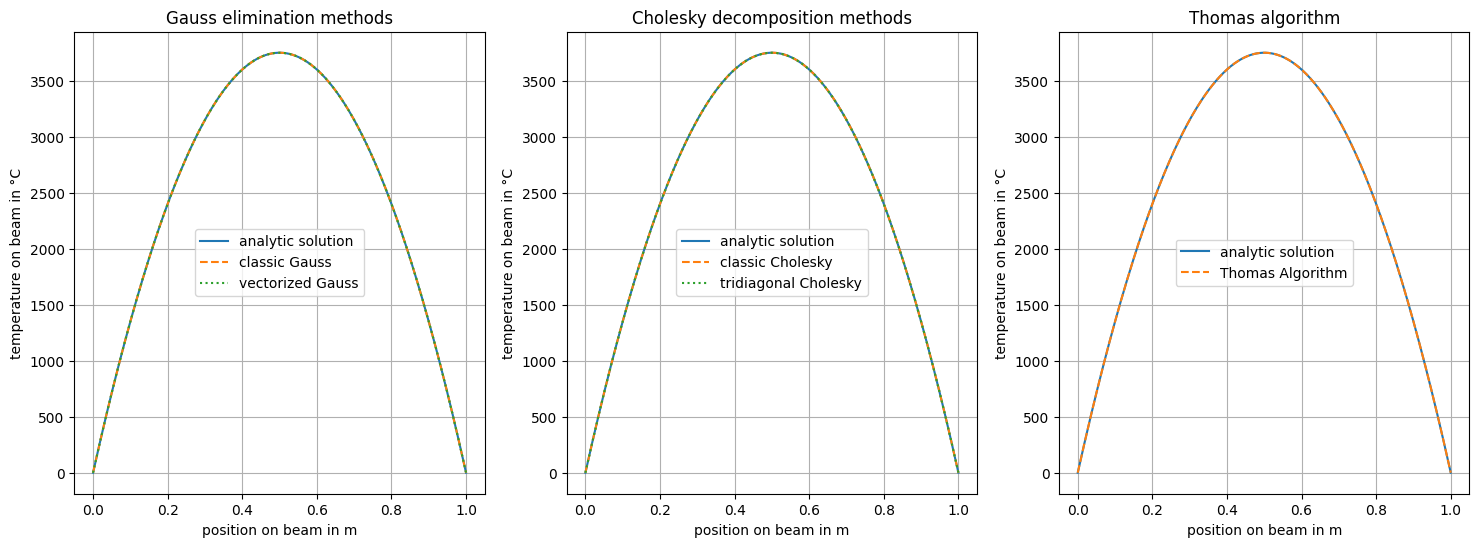

In [16]:
T_gauss = classic_gauss(A, b)

T_vec_gauss = vector_gauss(A,b)

T_cholesky = cholesky(A, b)

T_cholesky_tridiag = tridiagonal_cholesky(A, b)

T_thomas = thomas_algorithm(A, b)

fig, ax = plt.subplots(1,3, figsize=(18,6))
for axis in ax:
    axis.plot(x, T_analytic, label="analytic solution")
    axis.grid()
    axis.set_xlabel("position on beam in m")
    axis.set_ylabel("temperature on beam in °C")
ax[0].plot(x, T_gauss, label="classic Gauss", linestyle="--")
ax[0].plot(x, T_vec_gauss, label="vectorized Gauss", linestyle=":")
ax[0].set_title("Gauss elimination methods")
ax[1].plot(x, T_cholesky, label="classic Cholesky", linestyle="--")
ax[1].set_title("Cholesky decomposition methods")
ax[1].plot(x, T_cholesky_tridiag, label="tridiagonal Cholesky", linestyle=":")
ax[2].plot(x, T_thomas, label="Thomas Algorithm", linestyle="--")
ax[2].set_title("Thomas algorithm")
for axis in ax: axis.legend(loc="center")
plt.show()

As can be seen, all the implemented methods yield a similar solution to the analytic one. The only difference between them is the execution time and the amount of memory needed, which is discussed further below.

### **Iterative Solving**
The system of equations is solved with each iterative solver and the results are compared to the analytical solution. There was also the attempt to investigate if using a **scipy.sparse.csr_matrix** instead of the full matrix $\utilde{A}$ would also work, as [CSR allows fast matrix multiplications](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) and saves memory.

Richardson did not converge!
Richardson ended after 10000 steps.

Steepest Gradient did not converge!
SG ended after 10000 steps.

CG ended after 249 steps.


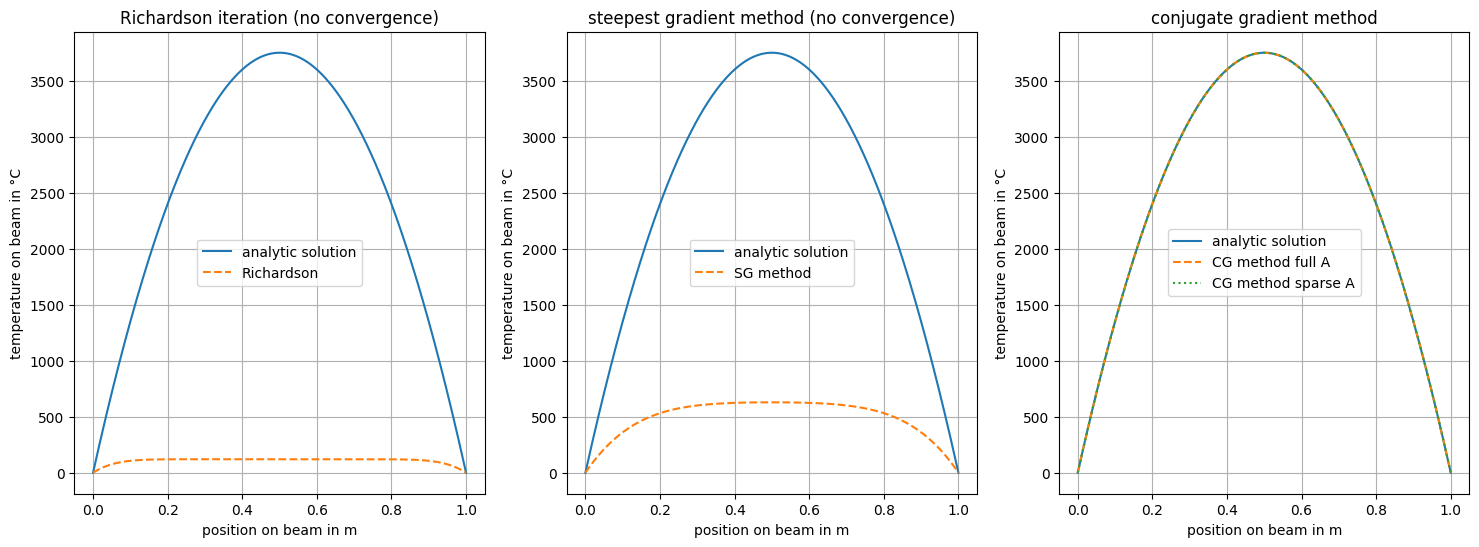

In [25]:
T_richard, residual_rich = richardson_iteration(A, b, np.zeros_like(b), 0.1, 10000, returnInfo=True)
print(f"Richardson ended after {len(residual_rich)} steps.\n")

T_steep_grad, residual_sg = steepest_gradient(A, b, np.zeros_like(b), 10000, returnInfo=True)
print(f"SG ended after {len(residual_sg)} steps.\n")

T_conj_grad, residual_cg = conjugate_gradient(A, b, np.zeros_like(b), 10000, returnInfo=True)
print(f"CG ended after {len(residual_cg)} steps.")

T_conj_sparse = conjugate_gradient(spA, b, np.zeros_like(b), 10000)

fig, ax = plt.subplots(1,3, figsize=(18,6))
for axis in ax:
    axis.plot(x, T_analytic, label="analytic solution")
    axis.grid()
    axis.set_xlabel("position on beam in m")
    axis.set_ylabel("temperature on beam in °C")
ax[0].plot(x, T_richard, label="Richardson", linestyle="--")
ax[0].set_title("Richardson iteration (no convergence)")
ax[1].plot(x, T_steep_grad, label="SG method", linestyle="--")
ax[1].set_title("steepest gradient method (no convergence)")
ax[2].plot(x, T_conj_grad, label="CG method full A", linestyle="--")
ax[2].plot(x, T_conj_sparse, label="CG method sparse A", linestyle=":")
ax[2].set_title("conjugate gradient method")
for axis in ax: axis.legend(loc="center")
plt.show()

In these experiments, the **Richardson iteration** and the **steepest gradient method** did not converge to the solution in $10000$ iterations. As $\utilde{A}$ is a SPD-matrix, the steepest gradient should converge; the fact that it did not is probably because of too little steps or due to the problem being "slightly" ill-conditioned ($\kappa\approx 100000$ for $n=500$). The **conjugate gradient method** converged without problems.

Text(0.5, 1.0, 'conjugate gradient method')

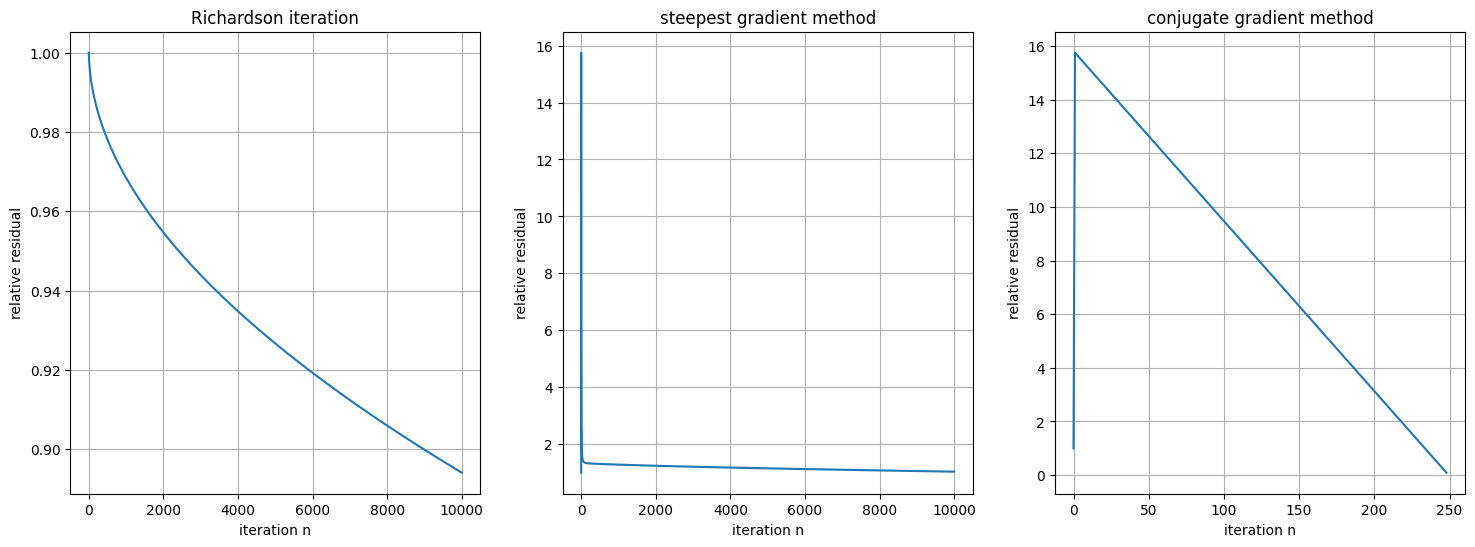

In [26]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
for axis in ax:
    axis.grid()
    axis.set_xlabel("iteration n")
    axis.set_ylabel("relative residual")
ax[0].plot(residual_rich, label="Richardson")
ax[0].set_title("Richardson iteration")
ax[1].plot(residual_sg, label="SG method")
ax[1].set_title("steepest gradient method")
ax[2].plot(residual_cg, label="CG method full A")
ax[2].set_title("conjugate gradient method")

### **Time performance over $n$**
The purpose of the following plot is to visualize the execution time of the algorithms over an increasing number of $n$. (This may take some time)

In [19]:
ns = [5, 10, 20, 50, 100, 200, 350, 500, 700]
t_cls_gauss, t_vec_gauss, t_cls_chol, t_trid_chol, t_numpy, t_thomas, t_cg, t_cg_sparse = [], [], [], [], [], [], [], []

for en in ns:
    An, bn = gen_system_of_eq(en)
    spAn = sp.csr_matrix(An)
    t_cls_gauss.append(timeit.timeit(stmt=lambda: classic_gauss(An,bn), number=1))
    t_vec_gauss.append(timeit.timeit(stmt=lambda: vector_gauss(An,bn), number=1))
    t_cls_chol.append(timeit.timeit(stmt=lambda: cholesky(An,bn), number=1))
    t_trid_chol.append(timeit.timeit(stmt=lambda: tridiagonal_cholesky(An,bn), number=1))
    t_numpy.append(timeit.timeit(stmt=lambda: solve_numpy(An,bn), number=1))
    t_thomas.append(timeit.timeit(stmt=lambda: thomas_algorithm(An,bn), number=1))
    t_cg.append(timeit.timeit(stmt=lambda: conjugate_gradient(An, bn, np.zeros_like(bn), 10000), number=1))
    t_cg_sparse.append(timeit.timeit(stmt=lambda: conjugate_gradient(spAn, bn, np.zeros_like(bn), 10000), number=1))

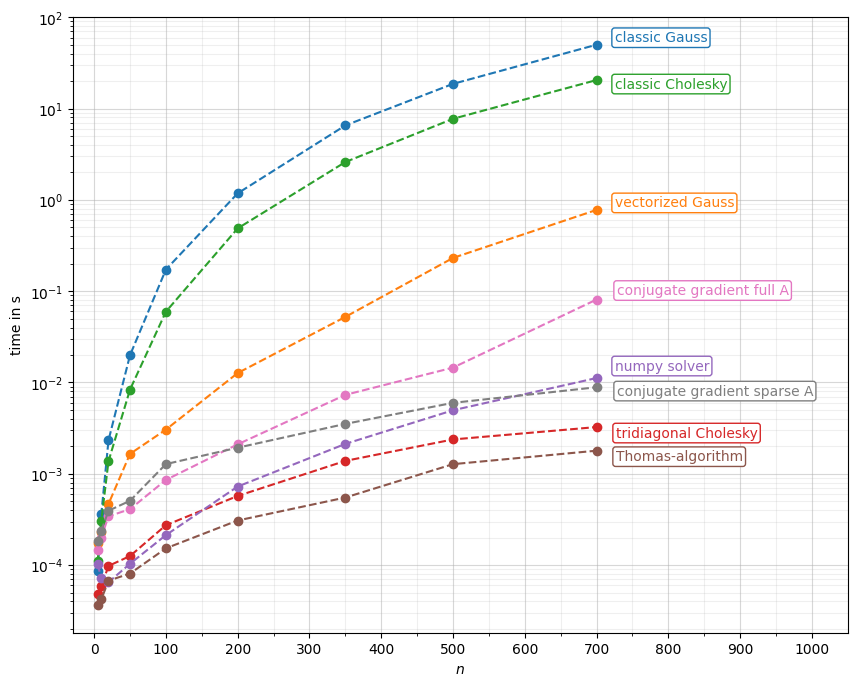

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.semilogy(ns, t_cls_gauss, label="classic Gauss", linestyle="--", marker="o")
ax.semilogy(ns, t_vec_gauss, label="vectorized Gauss", linestyle="--", marker="o")
ax.semilogy(ns, t_cls_chol, label="classic Cholesky", linestyle="--", marker="o")
ax.semilogy(ns, t_trid_chol, label="tridiagonal Cholesky", linestyle="--", marker="o")
ax.semilogy(ns, t_numpy, label="numpy solver", linestyle="--", marker="o")
ax.semilogy(ns, t_thomas, label="Thomas-algorithm", linestyle="--", marker="o")
ax.semilogy(ns, t_cg, label="conjugate gradient full A", linestyle="--", marker="o")
ax.semilogy(ns, t_cg_sparse, label="conjugate gradient sparse A", linestyle="--", marker="o")
ax.set_ylabel("time in s")
ax.set_xlabel(r"$n$")
ax.set_xticks(np.arange(0, 1001, 100))
ax.set_xticks(np.arange(0, 1001, 50), minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
ax.set_xlim(right=max(ns) * 1.5)

# plot name to last point
texts = []
for line in ax.get_lines():
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    
    texts.append(
        ax.text(
            x_data[-1]*1.03,
            y_data[-1],
            line.get_label(),
            color=line.get_color(),
            va='center',
            bbox=dict(
                boxstyle="round,pad=0.2",
                facecolor="white",
                edgecolor=line.get_color(),
                linewidth=1
            )
        )
    )

adjust_text(
    texts,
    ax=ax,
)

plt.show()

It is visible that the **classic Gauss elimination** and **Cholesky decomposition** take the longest time to execute. The special **vectorized Gauss elimination** comes next, followed by the **conjugate gradient method**. It is notable, that doing the calculations for **CG** with a *scipy.sparse.csr_matrix* object takes a larger amount of time for smaller $n$ but becomes more efficient the larger $n$ becomes, compared to always using the full matrix $\utilde{A}$.  
The fastest self-implemented algorithms are the **Cholesky decomposition for tridiagonal matrices** and the **Thomas-algorithm**.

### **Algorithm performance ranking**
Every algorithm has been run 5 times in succession with $n=500$, measuring the execution time and taking the average value. The results can be seen in the table below. The values obviously depend on the hardware. The code to evaluate is further [below](#solving-benchmark).

| Ranking | Method                                    | Execution time               | Theoretical memory needed for $\utilde{A}$ | est. number of operations         |
|---------|-------------------------------------------|------------------------------|--------------------------------------------|-----------------------------------|
| 1       | Thomas algorithm                          | $\approx 0.0012\,\mathrm{s}$ | $\approx 3\,n$                             | $5\,n+\mathcal{O}(1)$             |
| 2       | tridiagonal Cholesky decomp.              | $\approx 0.0028\,\mathrm{s}$ | $\approx 2\,n$                             | $6\,n+\mathcal{O}(1)$             |
| 3       | numpy.linalg.solve                        | $\approx 0.0038\,\mathrm{s}$ | unknown                                    | unknown                           |
| 4       | conjugate gradient w. sparse $\utilde{A}$ | $\approx 0.017\,\mathrm{s}$  | $\approx 7\,n$                             | $i\,(9\,n+\mathcal{O}(1))$        |
| 5       | conjugate gradient                        | $\approx 0.036\,\mathrm{s}$  | $\approx n^2$                              | $i\,(n^2+\mathcal{O}(n))$         |
| 6       | vectorized Gauss elimination              | $\approx 0.14\,\mathrm{s}$   | $\approx n^2$                              | $\dfrac{n^3}{3}+\mathcal{O}(n^2)$ |
| 7       | Cholesky decomp.                          | $\approx 4.90\,\mathrm{s}$   | $\approx \dfrac{n^2}{2}$                   | $\dfrac{n^3}{6}+\mathcal{O}(n^2)$ |
| 8       | classic Gauss elimination                 | $\approx 12.11\,\mathrm{s}$  | $\approx n^2$                              | $\dfrac{n^3}{3}+\mathcal{O}(n^2)$ |
| 9       | steepest gradient                         | no convergence               | $n^2$ or $7\,n$ w. sparse $\utilde{A}$     | $i\,(n^2+\mathcal{O}(n))$         |
| 10      | Richardson iteration                      | no convergence               | $n^2$ or $7\,n$ w. sparse $\utilde{A}$     | $i\,(n^2+\mathcal{O}(n))$         |

The column *Theoretical memory needed* describes how many floating point numbers need to be saved in memory to depict $\utilde{A}$. This is solely a thought experiment and heavily depends on how the algorithms are implemented. Even the **classic Gauss elimination**, needing $n^2$, could be implemented to use the advantage of sparsity. It is also worth noting that for simplicity even the memory optimised algorithms that have been implemented take the full matrix as a function parameter and only use certain parts from there.

The $3\,n$ and $2\,n$ from **Thomas** and **tridiagonal Cholesky** come from the three/two arrays needed to depict the diagonals. The **scipy.sparse.csr_matrix** saves the values, indices and pointer-indices which need $\approx 3\,n + 3\,n + n$ numbers, leading to $\approx 7\,n$.  

The approximate amount of operations needed for every algorithm come from these considerations:

$1$ operation $=$ $1$ multiplication + $1$ addition/subtraction  
$1$ operation $=$ $1$ division

| Algorithm | Thought process |
|---|---|
| Gauss | Complexity discussed in lecture, $\dfrac{n^3}{3}+\mathcal{O}(n^2)$ |
| Cholesky | Complexity discussed in lecture, $\dfrac{n^3}{6}+\mathcal{O}(n^2)$ |
| CG | The most expensive calculation is a matrix-vector multiplication, specifically $\utilde{A}\,\vec{s}$, which takes $n$ multiplications and $n-1$ additions per row, so $\approx n$ operations per row, which  results in $n^2$ for the whole matrix. This means the total complexity is $i\,(n^2+\mathcal{O}(n))$, where $i$ is the number of iterations. |
| CG w. sparse $\utilde{A}$ | When using the tridiagonal structure, the matrix-vector multiplication consists of only $3$ multiplications and $2$ additions, so $\approx 3$ operations, resulting in $3\,n$ for  the entire matrix. Then, $3$ dot-products are needed, adding another $3\,n$ operations and another $3\,n$ through updating $\vec{x}, \vec{r}$ and $\vec{s}$. This results in a complexity of $i\,(9\,n+\mathcal{O}(1))$, where $i$ is the number of iterations. |
| tridiagonal Cholesky | The factorisation requires $(n-1)$ divisions, multiplications and subtractions. The resulting complexity is $2\,(n-1)$. The forward and backward substitution also both require $2\,(n-1)$ operations,  which means the resulting complexity is $6\,(n-1)$, which is $\approx 6\,n+\mathcal{O}(1)$. |
| Thomas-algorithm | The "sweep" requires $(n-1)$ divisions and $2\,(n-1)$ multiplications and subtractions, which results in $3\,(n-1)$ operations. The backward substitution uses $(n-1)$ divisions,  multiplications and subtractions, leading to $2\,(n-1)$ operations, which means the final complexity is $\approx 5\,n+\mathcal{O}(1)$. |

\\
\\
\\
#### **Solving benchmark**
Uncomment the section below to run the benchmark. It could take some time.  
Reduce **nodes** parameter under **System Parameters** [HERE](#system-parameters) if it is taking too long. The **Richardson iteration** and the **Steepest gradient method** are excluded because they did not converge.

In [21]:
cycles = 5

print("Performance direct solvers:")
print(f"Avg. execution time classic gauss: {timeit.timeit(stmt=lambda: classic_gauss(A,b), number=cycles)/cycles} seconds")
print(f"Avg. execution time vectorized gauss: {timeit.timeit(stmt=lambda: vector_gauss(A,b), number=cycles)/cycles} seconds")

print(f"Avg. execution time cholesky: {timeit.timeit(stmt=lambda: cholesky(A,b), number=cycles)/cycles} seconds")
print(f"Avg. execution time tridiagonal cholesky: {timeit.timeit(stmt=lambda: tridiagonal_cholesky(A,b), number=cycles)/cycles} seconds")

print(f"Avg. execution time numpy solve: {timeit.timeit(stmt=lambda: solve_numpy(A,b), number=cycles)/cycles} seconds")
print(f"Avg. execution time thomas algorithm: {timeit.timeit(stmt=lambda: thomas_algorithm(A,b), number=cycles)/cycles} seconds")


print("\nPerformance iterative solvers:")
print(f"Avg. execution time conjugate gradient: {timeit.timeit(stmt=lambda: conjugate_gradient(A, b, np.zeros_like(b), 10000), number=cycles)/cycles} seconds")
print(f"Avg. execution time conjugate gradient sparse A: {timeit.timeit(stmt=lambda: conjugate_gradient(spA, b, np.zeros_like(b), 10000), number=cycles)/cycles} seconds")

Performance direct solvers:
Avg. execution time classic gauss: 18.34101295999717 seconds
Avg. execution time vectorized gauss: 0.1631794400047511 seconds
Avg. execution time cholesky: 7.62380131999962 seconds
Avg. execution time tridiagonal cholesky: 0.002648400003090501 seconds
Avg. execution time numpy solve: 0.005323880002833903 seconds
Avg. execution time thomas algorithm: 0.001278940006159246 seconds

Performance iterative solvers:
Avg. execution time conjugate gradient: 0.015572139993309975 seconds
Avg. execution time conjugate gradient sparse A: 0.005738360015675426 seconds


exporting notebook to html in terminal via:
~~~
jupyter nbconvert thermalBar.ipynb --to html --template lab --theme dark
~~~